### Microplaces and Violence  
  
Violent crime in America rose in 2020. The Economist suggested in a June 5th article, "Reality bites" that crime is geographically concentrated in certain neighborhoods. 
  
The Department of Public Safety in Denver, CO responded with a letter stating that "violence is just concentrated in just a few microplaces, each about two blocks square. In Denver 38 microplaces, equivalent to 1.5% of our landmass, accounted for about 25% of all violence in 2020."  
  
Can we say the same of Chicago, IL?   

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import fidap
from config import api_key

# instantiate api connection
fidap = fidap.fidap_client(api_key=api_key)

In [4]:
chicago_violent_crime_2020 = fidap.sql("""
SELECT case_number, primary_type, ST_GEOGPOINT(latitude, longitude) AS geometry, date, description  
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020
AND location IS NOT NULL
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
""")

Potential Avenues Moving Forward:  
1) KMeans to identify clusters  
2) Group them by census block groups to identify block groups that are particularly vulnerable to such crime  
3) Figure out why?  

First, we should aggregate them by Chicago's wards to identify wards where violent crime counts a lot higher. 

In [9]:
# count of crime by ward
chicago_violent_crime_2020_ward = fidap.sql("""
SELECT COUNT(*) AS crime_count, ward
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
AND location IS NOT NULL
AND ward IS NOT NULL
GROUP BY ward
""")

# change type
chicago_violent_crime_2020_ward['ward'] = chicago_violent_crime_2020_ward['ward'].astype(str)

In [25]:
# wards with highest violent crime count
chicago_violent_crime_2020_ward.sort_values(by = 'crime_count', ascending=False).head(n = 5)

,crime_count,ward
38,3921,28
39,3449,24
42,3207,6
41,2728,20
45,2699,17


What does this actually look like on a map? 

In [10]:
# get chicago's wards boundaries
chicago_wards_url = "https://data.cityofchicago.org/api/geospatial/sp34-6z76?method=export&format=Shapefile"
chicago_wards = gpd.read_file(chicago_wards_url)

# chicago population by census block
chicago_pop_census_block_url = "https://data.cityofchicago.org/resource/5yjb-v3mj.csv"
chicago_pop_census_block = pd.read_csv(chicago_pop_census_block_url)

# chicago census_blocks boundaries
chicago_census_blocks_url = "https://data.cityofchicago.org/api/geospatial/mfzt-js4n?method=export&format=Shapefile"
chicago_census_blocks = gpd.read_file(chicago_census_blocks_url)

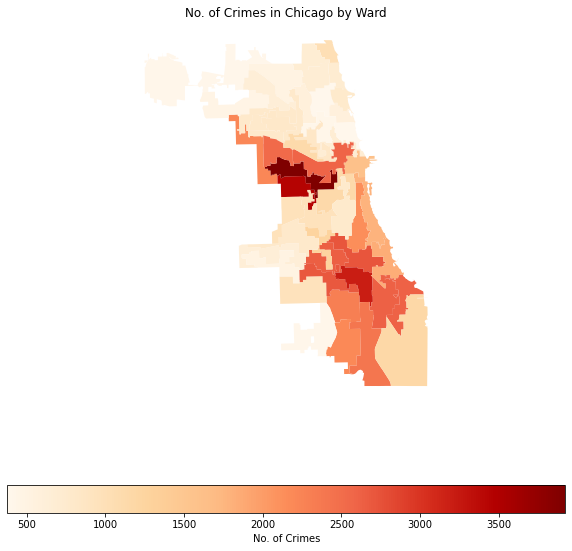

In [24]:
# join count of crime by ward to wards
chicago_wards_crime_count = chicago_wards.copy().merge(chicago_violent_crime_2020_ward)

# plot 
f, ax = plt.subplots(figsize = (10,10))
chicago_wards_crime_count.plot(ax = ax, column = 'crime_count', legend = True, cmap = "OrRd", 
                               legend_kwds = {
                                   'label': 'No. of Crimes',
                                   'orientation': 'horizontal'
                               })
ax.set_axis_off()
ax.set_title("No. of Crimes in Chicago by Ward")
plt.show()

It appears that there is some sort of spatial contiguity and concentration where crimes are concerned. Clearly, the rate of occurrence in some rates is a lot higher than others, and there is a stark difference among the wards in Chicago. 

In [28]:
chicago_crime_by_blockgroup = fidap.sql("""
WITH chicago_blocks AS(
SELECT geo_id, blockgroup_geom 
FROM bigquery-public-data.geo_census_blockgroups.blockgroups_17
WHERE county_fips_code = '031'
)

SELECT COUNT(*) AS crime_count, CAST(z.geo_id AS STR) AS geoid 
FROM bigquery-public-data.chicago_crime.crime AS c, chicago_blocks AS z
WHERE c.year = 2020
AND c.location IS NOT NULL
AND ST_CONTAINS(z.blockgroup_geom, ST_GEOGPOINT(c.longitude, c.latitude))
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
AND ward IS NOT NULL
GROUP BY z.geo_id;
""")

In [29]:
chicago_crime_blockgroup_count = chicago_census_blocks.merge(chicago_crime_by_blockgroup, left_on = 'geoid10', right_on = 'geo_id', how = 'left')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat